# Spline-informed Contextual GAN with LSTM Layers

The goal of this code is to provide a black box to approximate time-series data. Replace the cell defining "empiricalData" with the data you actually want to approximate and you should be able to just run the code. 

The code works by having a LSQ univariate spline approximate the data first, then feeds these prediction to the GAN. The spline does okay at getting the broad trend of most data patterns but it tends to miss the extreme maxima and minima, which is what the GAN is here to aim to handle better. The GAN is a contextual GAN with LSTM layers and direct pretraining. This allows quicker convergence without impacting performance negatively. If the data is particularly simple it may be appropriate to remove the pretraining stage to prevent the generator from dominating in the training process.

Training flags exist in the cell which defines the GAN so you can decide whether to train a new GAN, save a newly trained GAN, or load a GAN you already made. By default this code saves the data as splineData.txt and ganData.txt, but if you don't want this they're each a single line of code so very easy to edit out. 

There is of course a tradeoff between training time and the quality of the predictions. Here I have picked numbers which get a reasonably good approximation to the data within ~ 5 minutes on a decent machine. You may want to try different numbers if the data you're approximating is more complex or if you have a very powerful machine. 

# Imports

In [1]:
import numpy as np
import pandas as pd
import random as r
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import LSQUnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline

# Seeding

In [2]:
seed = True
if seed:
    r.seed(1)

# Data

I can't publish the real data I was working with when I made this code, so instead I made up a function and had the code deal with the function I made up. For convenience's sake I still name the data "empiricalData", and if you were going to actually use this code you'd want to replace the next cell with code that loads in your real data.

In [3]:
def dataFunction(i):
    return(r.uniform(0, 0.1) + (np.sin(np.pi * i) / (i + 1)) * np.e ** (i / 100))
empiricalData = [dataFunction(i * 10 ** -4) for i in range(10 ** 5)]

# Spline

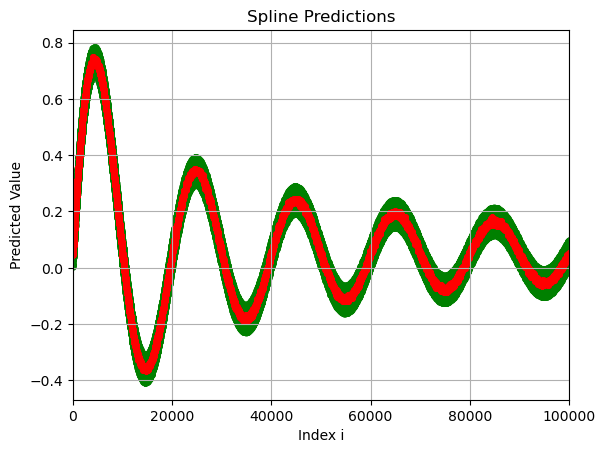

In [4]:
yValues = np.asarray(empiricalData, dtype = np.float64).ravel()
xValues = np.arange(len(yValues), dtype = np.float64)
knotInterval = 50
knots = xValues[knotInterval:-knotInterval:knotInterval]
splineModel = LSQUnivariateSpline(xValues, yValues, knots, k = 3)
xPredictionPoints = np.arange(len(yValues), dtype = np.float64)
splinePredictions = splineModel(xPredictionPoints)

plt.figure()
plt.scatter(np.arange(len(yValues)), yValues, s = 12, color = "green", label = "Empirical")
plt.scatter(xPredictionPoints, splinePredictions, s = 12, color = "red", label = "Spline")
plt.xlabel("Index i")
plt.ylabel("Predicted Value")
plt.title("Spline Predictions")
plt.grid(True)
plt.xlim(0, len(splinePredictions))
plt.show()

np.savetxt("splineData.txt", np.asarray(splinePredictions, dtype = np.float64), fmt = "%.10g")

# GAN

Epoch 25/25: 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]


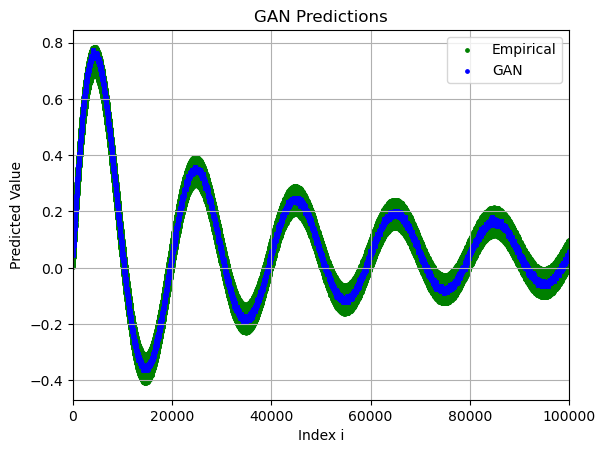

In [5]:
trainFlag = True
saveFlag = True
loadFlag = False

basePath = "gan"

sequenceLength = 5
conditionDimension = 1
dataDimension = 1

lstmUnits = 64

pretrainingEpochs = 25
pretrainingBatchSize = 128
pretrainingStepsPerEpoch = 20
pretrainingSeed = 321
pretrainLearningRate = 1e-4

trainingEpochs = 25
trainingBatchSize = 125
trainingStepsPerEpoch = 25
trainingSeed = 123
generatorLearningRate = 1e-4
discriminatorLearningRate = 1e-4
discThreshold = 0.5

dtwGamma = 0.1
dtwInfLarge = 1e9

windowStride = 1

indexBatchMode = "withReplacement"

plotPointSize = 6

def buildGenerator(sequenceLength, conditionDimension, outputDimension):
    conditionInput = layers.Input(shape = (sequenceLength, conditionDimension))
    x = layers.LSTM(lstmUnits, return_sequences = True)(conditionInput)
    x = layers.LSTM(lstmUnits, return_sequences = True)(x)
    output = layers.TimeDistributed(layers.Dense(outputDimension))(x)
    return(Model(conditionInput, output, name = "generator"))

def buildDiscriminator(sequenceLength, conditionDimension, dataDimension):
    dataInput = layers.Input(shape = (sequenceLength, dataDimension))
    conditionInput = layers.Input(shape = (sequenceLength, conditionDimension))
    merged = layers.Concatenate(axis = -1)([dataInput, conditionInput])
    x = layers.LSTM(lstmUnits, return_sequences = True)(merged)
    x = layers.LSTM(lstmUnits)(x)
    output = layers.Dense(1, activation = "sigmoid")(x)
    return(Model([dataInput, conditionInput], output, name = "discriminator"))

def calculatePairwiseDistances(seriesX, seriesY):
    xx = tf.reduce_sum(tf.square(seriesX), axis = -1)
    yy = tf.reduce_sum(tf.square(seriesY), axis = -1)
    return(xx[..., :, None] + yy[..., None, :] - 2.0 * tf.matmul(seriesX, seriesY, transpose_b = True))

def computeSoftDtw(distanceMatrix, gamma = dtwGamma):
    batchSize = tf.shape(distanceMatrix)[0]
    sequenceLengthX = tf.shape(distanceMatrix)[1]
    sequenceLengthY = tf.shape(distanceMatrix)[2]
    infConst = tf.constant(dtwInfLarge, dtype = distanceMatrix.dtype)
    accumulated = tf.fill([batchSize, sequenceLengthX + 1, sequenceLengthY + 1], infConst)
    batchIndex = tf.range(batchSize, dtype = tf.int32)[:, None]
    accumulated = tf.tensor_scatter_nd_update(
        accumulated,
        tf.concat([batchIndex,
                   tf.zeros([batchSize, 1], tf.int32),
                   tf.zeros([batchSize, 1], tf.int32)], axis = 1),
        tf.zeros([batchSize], distanceMatrix.dtype)
    )
    i = tf.constant(1, dtype = tf.int32)
    def outerCondition(i, accumulated):
        return(tf.less(i, sequenceLengthX + 1))
    def outerBody(i, accumulated):
        j = tf.constant(1, dtype = tf.int32)
        def innerCondition(j, accumulated):
            return(tf.less(j, sequenceLengthY + 1))
        def innerBody(j, accumulated):
            r0 = accumulated[:, i - 1, j]
            r1 = accumulated[:, i, j - 1]
            r2 = accumulated[:, i - 1, j - 1]
            rMin = tf.minimum(tf.minimum(r0, r1), r2)
            softMin = -gamma * tf.math.log(
                tf.exp((r0 - rMin) / -gamma) +
                tf.exp((r1 - rMin) / -gamma) +
                tf.exp((r2 - rMin) / -gamma)
            ) + rMin
            updateVal = distanceMatrix[:, i - 1, j - 1] + softMin
            index = tf.concat([batchIndex,
                               tf.fill([batchSize, 1], i),
                               tf.fill([batchSize, 1], j)], axis = 1)
            accumulated = tf.tensor_scatter_nd_update(accumulated, index, updateVal)
            return(j + 1, accumulated)
        k, accumulated = tf.while_loop(innerCondition, innerBody, [j, accumulated], parallel_iterations = 1)
        return(i + 1, accumulated)
    k, accumulated = tf.while_loop(outerCondition, outerBody, [i, accumulated], parallel_iterations = 1)
    return(accumulated[:, -1, -1])

def computeSoftDtwLoss(seriesX, seriesY, gamma = dtwGamma):
    distanceMatrix = calculatePairwiseDistances(seriesX, seriesY)
    return(computeSoftDtw(distanceMatrix, gamma = gamma))

def generateIndexBatches(datasetSize, batchSize, stepsPerEpoch, mode = indexBatchMode, rng = None):
    rngObj = np.random.default_rng(rng)
    if mode == "withReplacement":
        for r in range(stepsPerEpoch):
            yield rngObj.integers(low = 0, high = datasetSize, size = batchSize)
    else:
        takeCount = stepsPerEpoch * batchSize
        if takeCount > datasetSize:
            repetitions = int(np.ceil(takeCount / datasetSize))
            pool = np.concatenate([rngObj.permutation(datasetSize) for t in range(repetitions)])
            pool = pool[:takeCount]
        else:
            pool = rngObj.permutation(datasetSize)[:takeCount]
        for b in range(stepsPerEpoch):
            start = b * batchSize
            yield pool[start:start + batchSize]

def convertTo3dSliding(realArray, conditionArray, T, stride = windowStride):
    realArray = np.asarray(realArray, dtype = np.float32).ravel()
    conditionArray = np.asarray(conditionArray, dtype = np.float32).ravel()
    n = min(realArray.size, conditionArray.size)
    realArray = realArray[:n]
    conditionArray = conditionArray[:n]
    if n < T:
        raise ValueError("Series shorter than sequenceLength.")
    windows = 1 + (n - T) // stride
    real3d = np.stack([realArray[a * stride:a * stride + T] for a in range(windows)], axis = 0)[..., None]
    condition3d = np.stack([conditionArray[a * stride:a * stride + T] for a in range(windows)], axis = 0)[..., None]
    return(real3d, condition3d, n)

def reconstructFromWindowsMean(pred3d, T, totalLen, stride = windowStride):
    pred3d = np.asarray(pred3d, dtype = np.float32)
    numWindows = pred3d.shape[0]
    out = np.zeros(totalLen, dtype = np.float32)
    cnt = np.zeros(totalLen, dtype = np.float32)
    for w in range(numWindows):
        start = w * stride
        end = start + T
        out[start:end] += pred3d[w, :, 0]
        cnt[start:end] += 1.0
    cnt[cnt == 0] = 1.0
    return(out / cnt)

def convertToPredictiveWindows(series, T, H, stride = 1):
    series = np.asarray(series, dtype = np.float32).ravel()
    n = series.size
    windows = 1 + (n - (T + H)) // stride
    past3d = np.stack([series[a * stride:a * stride + T] for a in range(windows)], axis = 0)[..., None]
    future3d = np.stack([series[a * stride + T:a * stride + T + H] for a in range(windows)], axis = 0)[..., None]
    return(past3d, future3d)

def trainDataFromSeries(series, T, H, stride = 1):
    condition3d, real3d = convertToPredictiveWindows(series, T, H, stride = stride)
    return(real3d, condition3d)

def rolloutAutoregressive(generator, seedSegment, steps, horizon = 1):
    seedSegment = np.asarray(seedSegment, dtype = np.float32).reshape(1, -1, 1)
    history = seedSegment.copy()
    preds = []
    total = steps if horizon == 1 else int(np.ceil(steps / horizon))
    for r in range(total):
        nextChunk = generator(tf.convert_to_tensor(history[:, -seedSegment.shape[1]:, :], dtype = tf.float32), training = False).numpy()
        preds.append(nextChunk[:, :horizon, :])
        history = np.concatenate([history, nextChunk], axis = 1)
    predsCat = np.concatenate(preds, axis = 1)[:, :steps, :]
    return(predsCat[0, :, 0])

def pretrainGeneratorToSpline(generator, splinePredictions, sequenceLength,
                              epochs = pretrainingEpochs, batchSize = pretrainingBatchSize,
                              stepsPerEpoch = pretrainingStepsPerEpoch, mode = indexBatchMode,
                              seed = pretrainingSeed, learningRate = pretrainLearningRate):
    mse = tf.keras.losses.MeanSquaredError()
    opt = tf.keras.optimizers.Adam(learningRate)
    datasetSize = len(splinePredictions)
    def batchIterator(e):
        return(generateIndexBatches(datasetSize = datasetSize, batchSize = batchSize,
                                    stepsPerEpoch = stepsPerEpoch, mode = mode, rng = seed + e))
    for epoch in range(epochs):
        progress = tqdm(batchIterator(epoch), total = stepsPerEpoch, desc = f"Pretrain {epoch+1}/{epochs}", leave = True)
        for batchIndices in progress:
            conditionBatch = tf.convert_to_tensor(splinePredictions[batchIndices], dtype = tf.float32)
            with tf.GradientTape() as tape:
                pred = generator(conditionBatch, training = True)
                loss = mse(conditionBatch, pred)
            grads = tape.gradient(loss, generator.trainable_variables)
            opt.apply_gradients(zip(grads, generator.trainable_variables))

def trainGanUniformSampling(generator, discriminator, empiricalData, splinePredictions,
                            epochs = trainingEpochs, batchSize = trainingBatchSize,
                            stepsPerEpoch = trainingStepsPerEpoch, gamma = dtwGamma,
                            mode = indexBatchMode, seed = trainingSeed,
                            discThresholdVal = discThreshold,
                            genLearningRate = generatorLearningRate,
                            discLearningRate = discriminatorLearningRate):
    datasetSize = len(empiricalData)
    binaryCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)
    generatorOptimizer = tf.keras.optimizers.Adam(genLearningRate)
    discriminatorOptimizer = tf.keras.optimizers.Adam(discLearningRate)
    lastTrainedDiscLoss = float("inf")
    for epoch in range(epochs):
        batchIterator = generateIndexBatches(datasetSize = datasetSize, batchSize = batchSize,
                                             stepsPerEpoch = stepsPerEpoch, mode = mode, rng = seed + epoch)
        progress = tqdm(batchIterator, total = stepsPerEpoch, desc = f"Epoch {epoch+1}/{epochs}", leave = True)
        for batchIndices in progress:
            realBatch = tf.convert_to_tensor(empiricalData[batchIndices], dtype = tf.float32)
            conditionBatch = tf.convert_to_tensor(splinePredictions[batchIndices], dtype = tf.float32)
            trainDiscriminator = (lastTrainedDiscLoss > discThresholdVal)
            if trainDiscriminator:
                with tf.GradientTape() as tapeD:
                    fakeBatchD = generator(conditionBatch, training = True)
                    dReal = discriminator([realBatch, conditionBatch], training = True)
                    dFake = discriminator([fakeBatchD, conditionBatch], training = True)
                    lossReal = binaryCrossEntropy(tf.ones_like(dReal), dReal)
                    lossFake = binaryCrossEntropy(tf.zeros_like(dFake), dFake)
                    discriminatorLoss = (lossReal + lossFake) / 2.0
                dGrads = tapeD.gradient(discriminatorLoss, discriminator.trainable_variables)
                discriminatorOptimizer.apply_gradients(zip(dGrads, discriminator.trainable_variables))
                lastTrainedDiscLoss = float(discriminatorLoss.numpy())
            else:
                fakeBatchEval = generator(conditionBatch, training = False)
                dRealEval = discriminator([realBatch, conditionBatch], training = False)
                dFakeEval = discriminator([fakeBatchEval, conditionBatch], training = False)
                lossRealEval = binaryCrossEntropy(tf.ones_like(dRealEval), dRealEval)
                lossFakeEval = binaryCrossEntropy(tf.zeros_like(dFakeEval), dFakeEval)
                tempVal = float(((lossRealEval + lossFakeEval) / 2.0).numpy())
            with tf.GradientTape() as tapeG:
                fakeBatchG = generator(conditionBatch, training = True)
                dFakeForG = discriminator([fakeBatchG, conditionBatch], training = False)
                adversarialLoss = binaryCrossEntropy(tf.ones_like(dFakeForG), dFakeForG)
                dtwLoss = tf.reduce_mean(computeSoftDtwLoss(realBatch, fakeBatchG, gamma = gamma))
                generatorLoss = adversarialLoss + dtwLoss
            gGrads = tapeG.gradient(generatorLoss, generator.trainable_variables)
            generatorOptimizer.apply_gradients(zip(gGrads, generator.trainable_variables))

def saveGan(generator, discriminator, basePath):
    generator.save(basePath + "_generator.keras")
    discriminator.save(basePath + "_discriminator.keras")

def loadGan(basePath):
    gen = load_model(basePath + "_generator.keras")
    disc = load_model(basePath + "_discriminator.keras")
    return(gen, disc)

realData, conditionData, totalLen = convertTo3dSliding(empiricalData, splinePredictions, sequenceLength, stride = windowStride)

if loadFlag:
    generator, discriminator = loadGan(basePath)
else:
    generator = buildGenerator(sequenceLength, conditionDimension, dataDimension)
    discriminator = buildDiscriminator(sequenceLength, conditionDimension, dataDimension)

if trainFlag:
    pretrainGeneratorToSpline(generator, conditionData, sequenceLength,
                              epochs = pretrainingEpochs, batchSize = pretrainingBatchSize,
                              stepsPerEpoch = pretrainingStepsPerEpoch, mode = indexBatchMode,
                              seed = pretrainingSeed, learningRate = pretrainLearningRate)
    trainGanUniformSampling(generator, discriminator, realData, conditionData,
                            epochs = trainingEpochs, batchSize = trainingBatchSize,
                            stepsPerEpoch = trainingStepsPerEpoch, gamma = dtwGamma,
                            mode = indexBatchMode, seed = trainingSeed,
                            discThresholdVal = discThreshold,
                            genLearningRate = generatorLearningRate,
                            discLearningRate = discriminatorLearningRate)

if saveFlag:
    saveGan(generator, discriminator, basePath)

ganPred3d = generator(tf.convert_to_tensor(conditionData, dtype = tf.float32), training = False).numpy()
ganPredictions = reconstructFromWindowsMean(ganPred3d, sequenceLength, totalLen, stride = windowStride)
yValues = np.asarray(empiricalData, dtype = np.float64).ravel()[:totalLen]

plt.figure()
plt.scatter(np.arange(totalLen), yValues, s = plotPointSize, color = "green", label = "Empirical")
plt.scatter(np.arange(totalLen), ganPredictions, s = plotPointSize, color = "blue", label = "GAN")
plt.xlabel("Index i")
plt.ylabel("Predicted Value")
plt.title("GAN Predictions")
plt.grid(True)
plt.xlim(0, len(splinePredictions))
plt.legend()
plt.show()

np.savetxt("ganData.txt", ganPredictions, fmt = "%.10g")